In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ad_label = np.ones((250*6,), dtype=float)
ad_label[0:125] = 0
for k in range(35):
    ad_label[125+k] = k/35

In [5]:
ad_t0 = np.random.randint(125-50, 160+50, size=(5000,), dtype=int)

In [ ]:
ad_label[slice(ad_t0, ad_t0+50, 1)]

In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Global Attention Mechanism
class feature_attention(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=5, rate=4):
        super(feature_attention, self).__init__()
        self.nconv = nn.Conv2d(input_dim, output_dim, kernel_size=(1, 1))
        self.channel_attention = nn.Sequential(  
            nn.Linear(output_dim, int(output_dim / rate)),  
            nn.ReLU(inplace=True),  
            nn.Linear(int(output_dim / rate), output_dim)  
        )
        self.spatial_attention = nn.Sequential(  
            nn.Conv2d(output_dim, int(output_dim / rate), kernel_size=(1, kernel_size), padding=(0, (kernel_size - 1) // 2)),  
            nn.BatchNorm2d(int(output_dim / rate)),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(int(output_dim / rate), output_dim, kernel_size=(1, kernel_size), padding=(0, (kernel_size - 1) // 2)),  
            nn.BatchNorm2d(output_dim)  
        )
        
    def forward(self, x):
        x = x.permute(0, 3, 2, 1)  # [B, D, N, T]
        x = self.nconv(x)  # 扩展数据的特征维度
        b, c, n, t = x.shape  
        x_permute = x.permute(0, 2, 3, 1)  # [B, N, T, C]
        x_att_permute = self.channel_attention(x_permute) 
        x_channel_att = x_att_permute.permute(0, 3, 1, 2)  # [B, C, N, T]
        x = x * x_channel_att
        x_spatial_att = self.spatial_attention(x).sigmoid()
        out = x * x_spatial_att
        return out.permute(0, 3, 2, 1)

class AVWGCN(nn.Module):
    def __init__(self, in_dim, out_dim, cheb_k, embed_dim):
        """
        :param in_dim: 输入维度
        :param out_dim: 输出维度
        :param cheb_k: 切比雪夫多项式的阶，默认为3
        :param embed_dim: 节点的嵌入维度
        """
        super(AVWGCN, self).__init__()
        self.cheb_k = cheb_k
        self.weights_pool = nn.Parameter(torch.FloatTensor(embed_dim, cheb_k, in_dim, out_dim))
        self.bias_pool = nn.Parameter(torch.FloatTensor(embed_dim, out_dim))

    def forward(self, x, node_embedding):
        """
        :param x: (B, N, C_in)
        :param node_embedding: (N, D), 这里的node_embedding是可学习的
        :return: (B, N, C_out)
        """
        node_num = node_embedding.shape[0]
        # 自适应的学习节点间的内在隐藏关联获取邻接矩阵
        # D^(-1/2)AD^(-1/2)=softmax(ReLU(E * E^T)) - (N, N)
        support = F.softmax(F.relu(torch.mm(node_embedding, node_embedding.transpose(0, 1))), dim=1)
        # 这里得到的support表示标准化的拉普拉斯矩阵
        support_set = [torch.eye(node_num).to(support.device), support]
        for k in range(2, self.cheb_k):
            # Z(k) = 2 * L * Z(k-1) - Z(k-2)
            support_set.append(torch.matmul(2 * support, support_set[-1]) - support_set[-2])
        supports = torch.stack(support_set, dim=0) # (K, N, N)
        # (N, D) * (D, K, C_in, C_out) -> (N, K, C_in, C_out)
        weights = torch.einsum('nd, dkio->nkio', node_embedding, self.weights_pool)
        # (N, D) * (D, C_out) -> (N, C_out)
        bias = torch.matmul(node_embedding, self.bias_pool)

        # 多阶切比雪夫计算：(K, N, N) * (B, N, C_in) -> (B, K, N, C_in)
        x_g = torch.einsum("knm,bmc->bknc", supports, x)  # (B, K, N, C_in) 很好奇为什么不在dim=1相加?
        x_g = x_g.permute(0, 2, 1, 3)  # (B, N, K, C_in) * (N, K, C_in, C_out)
        x_gconv = torch.einsum('bnki,nkio->bno', x_g, weights) + bias  # (B, N, C_out)
        return x_gconv

class AGCRNCell(nn.Module):
    def __init__(self, num_node, in_dim, out_dim, cheb_k, embed_dim):
        super(AGCRNCell, self).__init__()
        self.num_node = num_node
        self.hidden_dim = out_dim
        self.gate = AVWGCN(in_dim + out_dim, 2 * out_dim, cheb_k, embed_dim)
        self.update = AVWGCN(in_dim + out_dim, out_dim, cheb_k, embed_dim)

    def forward(self, x, state, node_embedding):
        # x: (B, N, C), state: (B, N, D)
        state = state.to(x.device)
        input_and_state = torch.cat((x, state), dim=-1)
        # 两个门控 forget、update
        z_r = torch.sigmoid(self.gate(input_and_state, node_embedding))
        z, r = torch.split(z_r, self.hidden_dim, dim=-1)
        candidate = torch.cat((x, r*state), dim=-1)
        hc = torch.tanh(self.update(candidate, node_embedding))
        h = z * state + (1 - z) * hc
        return h

    def init_hidden_state(self, batch_size):
        return torch.zeros(batch_size, self.num_node, self.hidden_dim)

class AVWDCRNN(nn.Module):
    def __init__(self, num_node, in_dim, out_dim, cheb_k, embed_dim, num_layers=1):
        super(AVWDCRNN, self).__init__()
        assert num_layers >= 1, "At least one DCRNN layer in the Encoder."
        self.num_node = num_node
        self.input_dim = in_dim
        self.num_layers = num_layers
        self.dcrnnn_cells = nn.ModuleList()
        self.dcrnnn_cells.append(AGCRNCell(num_node, in_dim, out_dim, cheb_k, embed_dim))
        for _ in range(1, num_layers):
            self.dcrnnn_cells.append(AGCRNCell(num_node, out_dim, out_dim, cheb_k, embed_dim))

    def forward(self, x, init_state, node_embedding):
        """
        :param x: (B, T, N, in_dim)
        :param init_state: (num_layers, B, N, hidden_dim)
        :param node_embedding: (N, D)
        :return:
        """
        seq_length = x.shape[1]
        current_inputs = x
        output_hidden = []
        for i in range(self.num_layers):
            state = init_state[i]
            inner_states = []
            for t in range(seq_length):
                state = self.dcrnnn_cells[i](current_inputs[:, t, :, :], state, node_embedding)
                inner_states.append(state)
            output_hidden.append(state)  # 最后一个时间步输出的隐藏状态
            current_inputs = torch.stack(inner_states, dim=1) # (B, T, N, hid_dim)

        # current_inputs: the outputs of last layer: (B, T, N, hidden_dim)
        # output_hidden: the last state for each layer: (num_layers, B, N, hidden_dim)
        output_hidden = torch.stack(output_hidden, dim=0)
        return current_inputs, output_hidden

    def init_hidden(self, batch_size):
        init_states = []  # 初始化隐藏层
        for i in range(self.num_layers):
            init_states.append(self.dcrnnn_cells[i].init_hidden_state(batch_size))
        return torch.stack(init_states, dim=0)  # (num_layers, B, N, hidden_dim)

class PositionalEncoding(nn.Module):
    def __init__(self, out_dim, max_len=12):
        super(PositionalEncoding, self).__init__()

        # compute the positional encodings once in log space.
        pe = torch.zeros(max_len, out_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, out_dim, 2) *
                             - math.log(10000.0) / out_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).unsqueeze(2)  # (1, T, 1, D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # (B, T, N, D) + (1, T, 1, D)
        x = x + Variable(self.pe.to(x.device), requires_grad=False)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        # 计算在时间维度上的多头注意力机制
        self.positional_encoding = PositionalEncoding(embed_size)
        self.embed_size = embed_size
        self.heads = heads
        # 要求嵌入层特征维度可以被heads整除
        assert embed_size % heads == 0
        self.head_dim = embed_size // heads   # every head dimension

        self.W_V = nn.Linear(self.embed_size, self.head_dim * heads, bias=False)
        self.W_K = nn.Linear(self.embed_size, self.head_dim * heads, bias=False)
        self.W_Q = nn.Linear(self.embed_size, self.head_dim * heads, bias=False)
        # LayerNorm在特征维度上操作
        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)

        self.fc = nn.Sequential(
            nn.Linear(self.embed_size, self.embed_size),
            nn.ReLU(),
            nn.Linear(self.embed_size, self.embed_size)
        )

    def forward(self, x):
        """
        :param x: [B, T, N, D]
        """
        batch_size, _, _, d_k = x.shape
        x = self.positional_encoding(x).permute(0, 2, 1, 3)   # [B, N, T, D]
        # 计算Attention的Q、K、V
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)
        Q = torch.cat(torch.split(Q, self.head_dim, dim=-1), dim=0)  # [k*B, N, T, d_k]
        K = torch.cat(torch.split(K, self.head_dim, dim=-1), dim=0)  # [k*B, N, T, d_k]
        V = torch.cat(torch.split(V, self.head_dim, dim=-1), dim=0)
        # 考虑上下文的长期依赖信息
        scores = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float))
        attention = F.softmax(scores, dim=-1)  # [k * B, N, T, T]
        context = torch.matmul(attention, V)   # context vector
        context = torch.cat(torch.split(context, batch_size, dim=0), dim=-1)
        context = context + x    # residual connection
        out = self.norm1(context)
        out = self.fc(out) + context  # residual connection
        out = self.norm2(out)
        return out

class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, adj, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.adj = adj
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h):
        # h: (B, T, N, D)
        Wh = torch.matmul(h, self.W)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.permute(0, 1, 3, 2)
        e = self.leakyrelu(e)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(self.adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        out = torch.matmul(attention, Wh)
        if self.concat:
            return F.elu(out)
        else:
            return out

class Model(nn.Module):
    def __init__(self, num_node, input_dim, hidden_dim, output_dim, embed_dim, cheb_k, horizon, num_layers, heads, timesteps, A, kernel_size):
        super(Model, self).__init__()
        self.A = A
        self.timesteps = timesteps
        self.num_node = num_node
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.horizon = horizon
        self.num_layers = num_layers

        # node embed
        self.node_embedding = nn.Parameter(torch.randn(self.num_node, embed_dim), requires_grad=True)
        # encoder
        self.feature_attention = feature_attention(input_dim=input_dim, output_dim=hidden_dim, kernel_size=kernel_size)
        self.encoder = AVWDCRNN(num_node, hidden_dim, hidden_dim, cheb_k, embed_dim, num_layers)
        self.GraphAttentionLayer = GraphAttentionLayer(hidden_dim, hidden_dim, A, dropout=0.5, alpha=0.2, concat=True)
        self.MultiHeadAttention = MultiHeadAttention(embed_size=hidden_dim, heads=heads)
        # predict
        self.nconv = nn.Conv2d(1, self.horizon, kernel_size=(1, 1), bias=True)
        self.end_conv = nn.Conv2d(hidden_dim, 1, kernel_size=(1, 1), bias=True)

    def forward(self, x):
        # x: (B, T, N, D)
        batch_size = x.shape[0]
        x = self.feature_attention(x)
        init_state = self.encoder.init_hidden(batch_size)
        output, _ = self.encoder(x, init_state, self.node_embedding)  # (B, T, N, hidden_dim)
        state = output[:, -1:, :, :]
        state = self.nconv(state)
        SAtt = self.GraphAttentionLayer(state)
        TAtt = self.MultiHeadAttention(output).permute(0, 2, 1, 3)
        out = SAtt + TAtt
        out = self.end_conv(out.permute(0, 3, 2, 1))  # [B, 1, N, T] -> [B, N, T]
        out = out.permute(0, 3, 2, 1)   # [B, T, N]
        return out

In [ ]:
from torchinfo import summary

summary(Model(), )

In [1]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000    # number of steps
)

training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()

# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

A100 GPU detected, using flash attention if input tensor is on cuda


/home/zhangxu/miniconda3/envs/ZX/lib/python3.8/contextlib.py:83: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([4, 3, 128, 128])

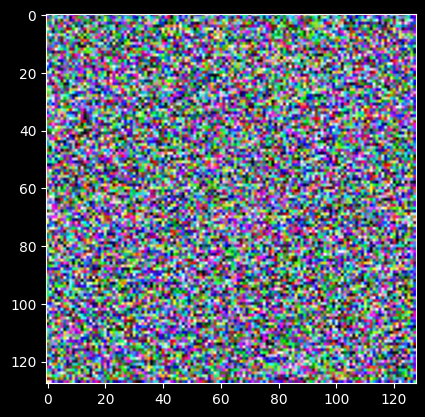

In [4]:
import matplotlib.pyplot as plt
plt.imshow(sampled_images[0].squeeze().permute(1,2,0).numpy())

In [1]:
from difflibs import Trainer_Diffusions, Config 
from torchinfo import summary
from denoising_diffusion_pytorch import *
from denoising_diffusion_pytorch.denoising_diffusion_pytorch_1d import cycle, num_to_groups, has_int_squareroot, exists

In [2]:

model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4),
    channels = 3
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 48,
    timesteps = 1000,
    objective = 'pred_v'
)


summary(diffusion, (2,3,48))

trainer = Trainer_Diffusions(
    Config(),
    diffusion
)
trainer.train()

# after a lot of training

sampled_seq = diffusion.sample(batch_size = 4)
sampled_seq.shape # (4, 32, 128)

7000 1400
construct filter bank
cutting data into 1 parts
finish filter...
loading data from 0 to 256
ssssssssssssssssssssssssssssssssssssssss (7000,) (7000,) (7000, 3, 9, 48) (7000, 3, 9, 48) (7000, 3, 9, 48) (7000, 48)
construct filter bank
cutting data into 1 parts
finish filter...
loading data from 0 to 256
ssssssssssssssssssssssssssssssssssssssss (1400,) (1400,) (1400, 3, 9, 48) (1400, 3, 9, 48) (1400, 3, 9, 48) (1400, 48)


  0%|          | 0/2000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

training complete


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([4, 3, 48])

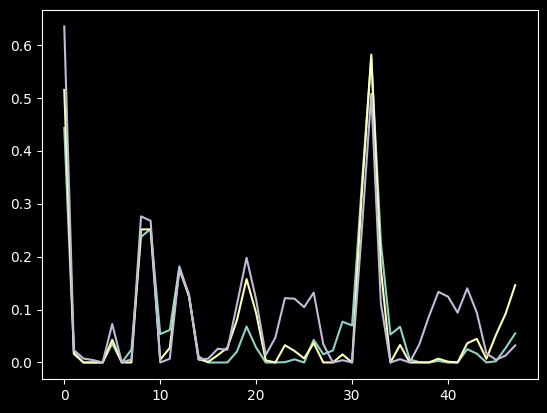

In [5]:
import matplotlib.pyplot as plt

plt.plot(sampled_seq[3].cpu().numpy().T)

plt.show()